In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
#Loading the data for modelling and the Yahoo stocks data
model_data = pd.read_csv('model_data.csv', index_col = [0]).interpolate() #We use interpolation to linearly fill missing data
yahoo_data = pd.read_csv('yahoo_data.csv', index_col = [0]).interpolate() 
model_data.head()

,AMD,GOOGL,MSFT,PSA,BLL,TSLA,AMZN,AAPL,NDAQ,DOW,...,IFF,WEC,XYL,SLG,NWL,RMD,VTR,ROST,NRG,LNC
2021-03-17,0.0,1.0,1.0,9.0,8.0,3.0,6.0,3.0,5.0,5.0,...,9.0,6.0,5.0,2.0,5.0,3.0,9.0,0.0,3.0,4.0
2021-03-18,9.0,2.0,5.0,6.0,4.0,8.0,7.0,5.0,8.0,8.0,...,9.0,4.0,4.0,9.0,0.0,5.0,7.0,9.0,0.0,4.0
2021-03-19,6.0,1.0,0.0,4.0,4.0,7.0,8.0,1.0,2.0,1.0,...,2.0,2.0,8.0,9.0,2.0,5.0,9.0,1.0,5.0,3.0
2021-03-20,3.0,2.0,3.0,4.0,8.0,3.0,6.0,3.0,3.0,6.0,...,9.0,1.0,2.0,6.0,3.0,2.0,0.0,4.0,0.0,5.0
2021-03-21,9.0,5.0,8.0,9.0,9.0,4.0,5.0,2.0,9.0,0.0,...,4.0,4.0,9.0,5.0,8.0,0.0,0.0,9.0,9.0,9.0


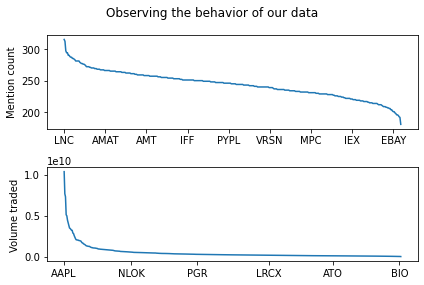

In [3]:
mention_count = model_data.sum(axis = 0).sort_values(ascending = False) #Number of total mentions for each stock
volume_traded = yahoo_data.sum(axis = 0).sort_values(ascending = False) #Amount of volume traded for each stock

#Plotting the mention count and volume traded for all stocks into simple graphs

fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Observing the behavior of our data')

ax1.plot(mention_count)
ax1.set_xticks(['LNC','AMAT','AMT','IFF','PYPL','VRSN','MPC','IEX','EBAY'])
ax1.set_ylabel('Mention count')


ax2.plot(volume_traded)
ax2.set_xticks(['AAPL', 'NLOK', 'PGR', 'LRCX', 'ATO', 'BIO'])
ax2.set_ylabel('Volume traded')

fig.tight_layout()
plt.show()

In [35]:
#We want to calculate daily percentage change in volume/mentions for a specific stock.
#However, some stocks get 0 mentions on several days, rendering the percentage change infinity on the next day.
#We replace this value with NaN and interpolate to get a continuous graph.

#Taking a look at the AAPL stock for a reference
aapl_mtn = model_data['AAPL'].pct_change().replace(np.inf,np.nan).interpolate()
aapl_vol = yahoo_data['AAPL'].pct_change().replace(np.inf,np.nan).interpolate()

#Merge the two series only on the matching indices
#aapl = pd.concat([aapl_mtn, aapl_vol], axis = 1, keys  = 'AAPL')
#print(aapl)
print(aapl_vol)

#aapl_mtn.plot()
#aapl_vol.plot()


#plt.show()


Date
May 14, 2021         NaN
May 13, 2021    0.294045
May 12, 2021    0.059616
May 11, 2021    0.124545
May 10, 2021   -0.301814
                  ...   
Dec 28, 2020    0.028410
Dec 24, 2020   -0.558745
Dec 23, 2020    0.606108
Dec 22, 2020    0.000000
Dec 21, 2020    0.000000
Name: AAPL, Length: 100, dtype: float64


In [11]:
#Calculate the differences between days
aapl_mtn_diff = aapl_mtn.diff()
aapl_vol_diff = aapl_vol.diff()

#Transfer the values into positive change, negative change or no change (make use of instancing)
differences = [aapl_mtn_diff, aapl_vol_diff]

for x in differences:
    for i in range(0,len(x)):
        if x[i] > 0:
            x[i] = 1
        elif x[i] < 0:
            x[i] = -1
        else:
            x[i] = 0

len(aapl_mtn_diff)
#len(aapl_vol_diff)

54

In [105]:
#Observe the correlation in the tendencies of the two measures (on the same day)
test_corr = np.corrcoef(aapl_mtn_diff.iloc[0:50], aapl_vol_diff.iloc[0:50])
print(test_corr)

[[1.         0.03849385]
 [0.03849385 1.        ]]
